# Predict shapes

In [1]:
import sys
sys.path.insert(0, "..")
import os
from glob import glob
import natsort
import json
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
from pathlib import Path
import shutil
import torch
import torch.nn as nn

from sklearn.metrics import confusion_matrix
from PIL import Image

In [2]:
from dataloader import load_images, load_masks, mask2rgb, rgb2mask, get_image_names
from lib import compose_image, plot_patches, input_filled_mirroring
from model import UNet, make_dataloaders, IoU, UnetFracture

In [3]:
PATH_PARAMETERS = '../params.json'

with open(PATH_PARAMETERS) as f:
    params = json.load(f)

model_params = params['shape_segmentation']['patches_floodnet']

In [4]:
mode = 'val'
file_names = get_image_names(mode=mode)
images = load_images(file_names,mode=mode)
masks = load_masks(file_names,mode=mode)

../../FloodNet-Supervised_v1.0_resized/val\val-org-img\*


(-0.5, 399.5, 299.5, -0.5)

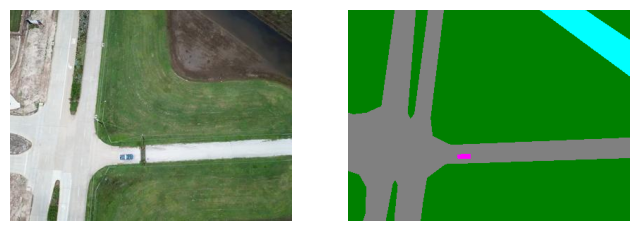

In [6]:
ix = 1

fig, ax = plt.subplots(1,2, figsize=(8,10))
ax[0].imshow(images[ix], cmap='gray')
ax[0].axis('off')
ax[1].imshow(masks[ix])
ax[1].axis('off')

In [7]:
model = UnetFracture(model_params)
model.initialize()

In [16]:
ix = 3
image = images[ix]
mask_rgb = masks[ix]
mask_labels = rgb2mask(mask_rgb).astype(int)

mask_prob = model.predict_proba(image)
mask_predict = model.predict_image(image)
mask_predict_rgb = mask2rgb(mask_predict)
class_iou, mean_iou = IoU(mask_labels, mask_predict, model_params['n_classes'])

D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


Class IoU: nan nan nan nan 0.917 0.914 nan nan nan 0.968   |  Mean IoU: 0.933


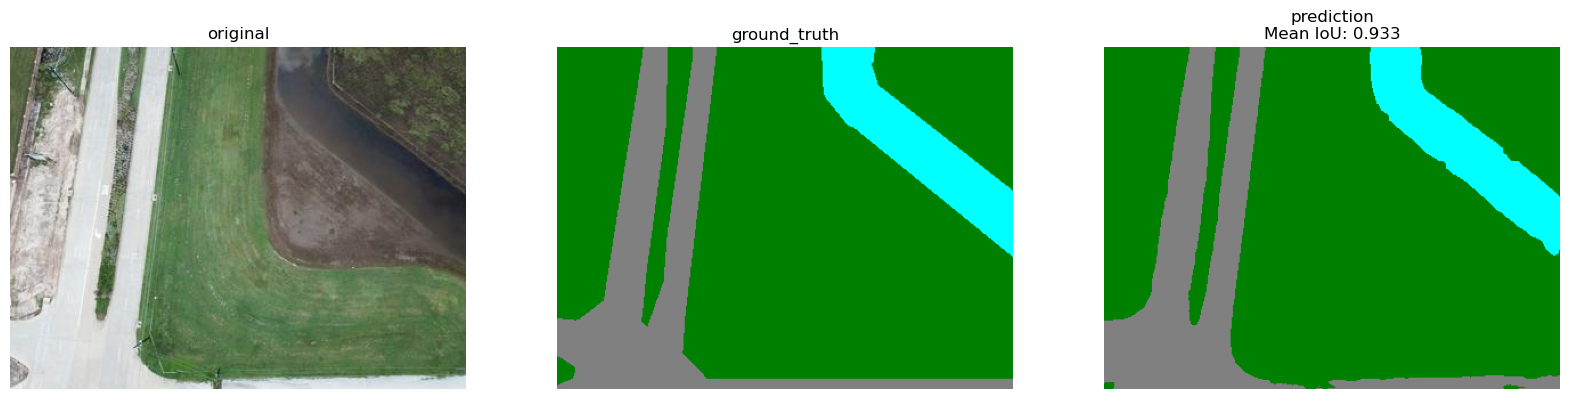

In [17]:
fig, ax = plt.subplots(1,3,figsize=(20,7))
ax[0].imshow(image)
ax[0].set_title('original')
ax[0].axis('off')
ax[1].imshow(mask_rgb)
ax[1].set_title('ground_truth')
ax[1].axis('off')
ax[2].imshow(mask_predict_rgb)
ax[2].set_title(f'prediction\nMean IoU: {mean_iou:.3f}')
ax[2].axis('off')

print('Class IoU:', ' '.join(f'{x:.3f}' for x in class_iou), f'  |  Mean IoU: {mean_iou:.3f}')

Class IoU: nan nan nan nan 0.917 0.914 nan nan nan 0.968   |  Mean IoU: 0.933


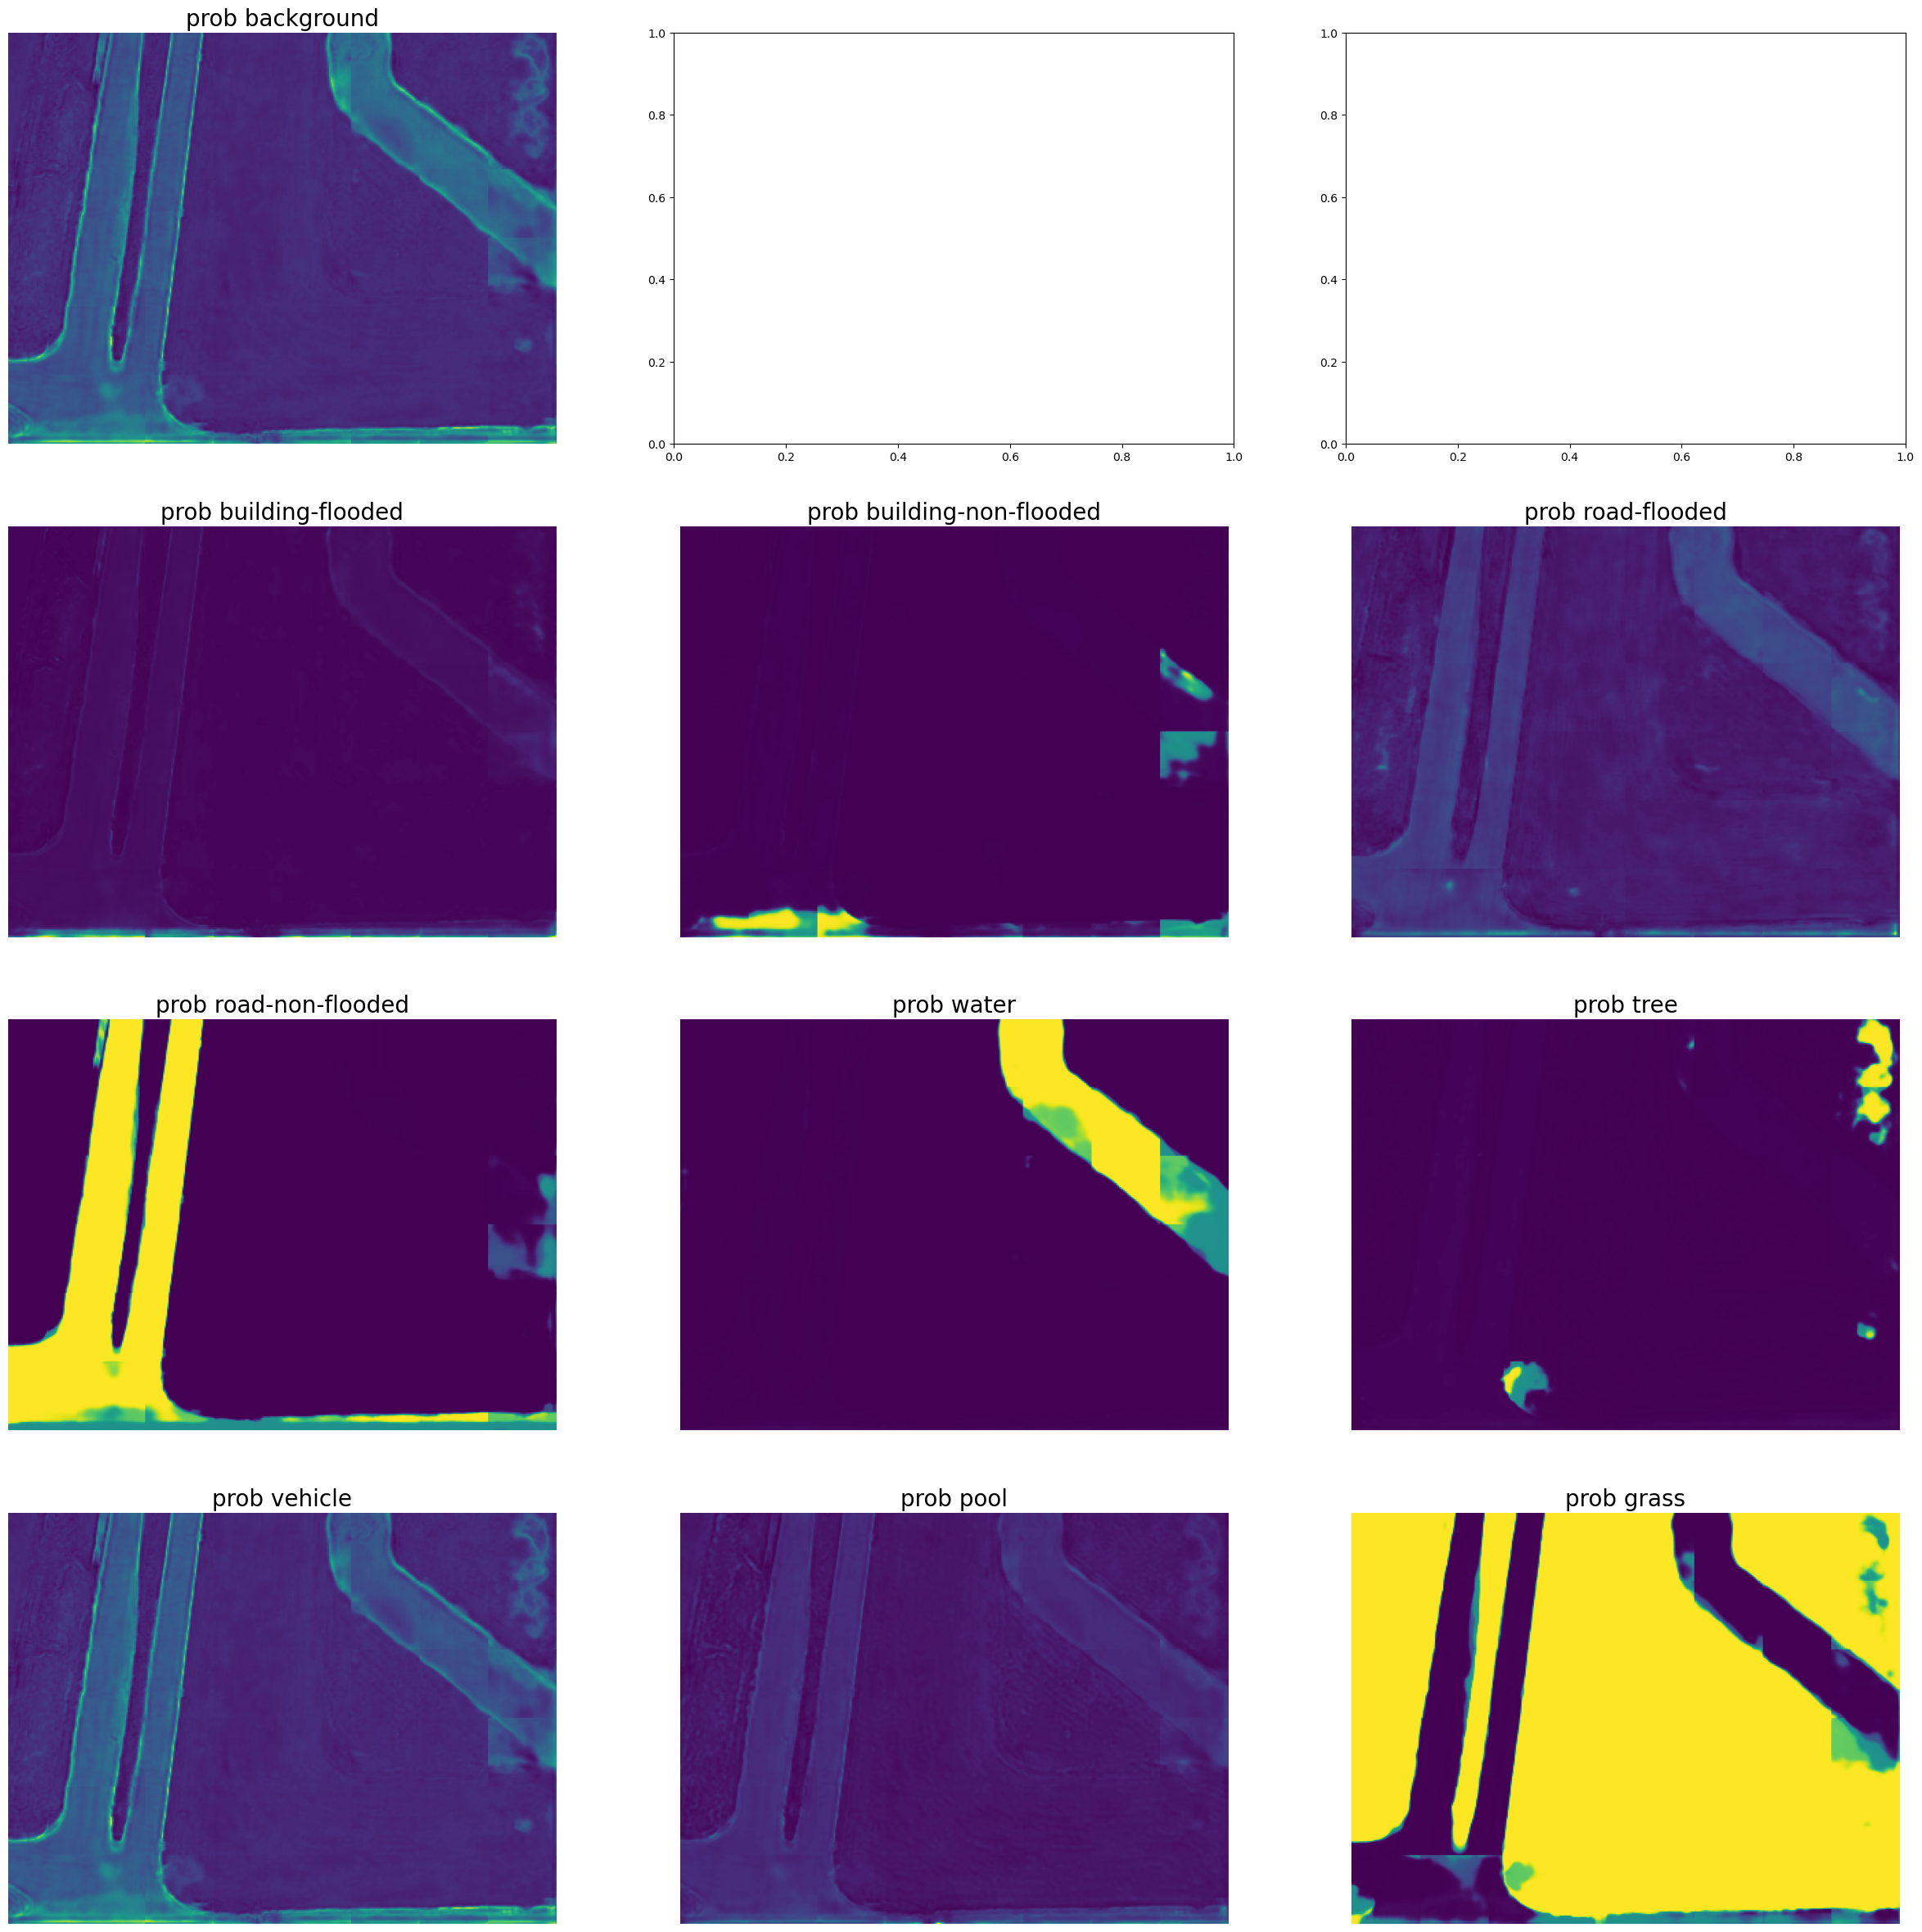

In [18]:
fig, ax = plt.subplots(4,3,figsize=(30,30))
ax[0][0].imshow(mask_prob[:,:,0])
ax[0][0].set_title('prob background', fontsize=20)
ax[0][0].axis('off')
ax[1][0].imshow(mask_prob[:,:,1])
ax[1][0].set_title('prob building-flooded', fontsize=20)
ax[1][0].axis('off')
ax[1][1].imshow(mask_prob[:,:,2])
ax[1][1].set_title('prob building-non-flooded', fontsize=20)
ax[1][1].axis('off')
ax[1][2].imshow(mask_prob[:,:,3])
ax[1][2].set_title('prob road-flooded', fontsize=20)
ax[1][2].axis('off')
ax[2][0].imshow(mask_prob[:,:,4])
ax[2][0].set_title('prob road-non-flooded', fontsize=20)
ax[2][0].axis('off')
ax[2][1].imshow(mask_prob[:,:,5])
ax[2][1].set_title('prob water', fontsize=20)
ax[2][1].axis('off')
ax[2][2].imshow(mask_prob[:,:,6])
ax[2][2].set_title('prob tree', fontsize=20)
ax[2][2].axis('off')
ax[3][0].imshow(mask_prob[:,:,7])
ax[3][0].set_title('prob vehicle', fontsize=20)
ax[3][0].axis('off')
ax[3][1].imshow(mask_prob[:,:,8])
ax[3][1].set_title('prob pool', fontsize=20)
ax[3][1].axis('off')
ax[3][2].imshow(mask_prob[:,:,9])
ax[3][2].set_title('prob grass', fontsize=20)
ax[3][2].axis('off')

print('Class IoU:', ' '.join(f'{x:.3f}' for x in class_iou), f'  |  Mean IoU: {mean_iou:.3f}')

In [22]:
m_ious = []
cf_ious = []
pred_masks = []
rgb_pred_masks = []
class_ious = []
for i, (image,mask_rgb) in enumerate(zip(images,masks)):
    
    mask_labels = rgb2mask(mask_rgb).astype(int)
    mask_prob = model.predict_proba(image)
    mask_predict = model.predict_image(image)
    mask_predict_rgb = mask2rgb(mask_predict)
    pred_masks.append(mask_predict)
    rgb_pred_masks.append(mask_predict_rgb)
    class_iou, mean_iou = IoU(mask_labels, mask_predict, model_params['n_classes'])
    class_ious.append(class_iou)
    m_ious.append(mean_iou)
    
    
    print(f'{i}: Class IoU:', ' '.join(f'{x:.3f}' for x in class_iou), f'  |  Mean IoU: {mean_iou:.3f}')
#     plot_results(img, img_bin, mask_rgb, img_prob, sines) 

D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


0: Class IoU: nan nan nan nan 0.937 0.922 0.000 0.000 nan 0.974   |  Mean IoU: 0.567


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


1: Class IoU: nan nan nan nan 0.901 0.907 nan 0.000 nan 0.958   |  Mean IoU: 0.692


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


2: Class IoU: nan 0.000 nan nan 0.946 0.864 0.000 0.000 nan 0.967   |  Mean IoU: 0.463


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


3: Class IoU: nan nan nan nan 0.917 0.914 nan nan nan 0.968   |  Mean IoU: 0.933


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


4: Class IoU: nan nan 0.000 nan 0.935 0.831 nan nan nan 0.973   |  Mean IoU: 0.685


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


5: Class IoU: nan nan nan nan 0.939 0.921 nan 0.000 nan 0.976   |  Mean IoU: 0.709


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


6: Class IoU: nan nan nan nan 0.921 0.974 nan nan nan 0.983   |  Mean IoU: 0.959


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


7: Class IoU: nan nan 0.000 nan 0.947 0.951 0.859 nan nan 0.984   |  Mean IoU: 0.748


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


8: Class IoU: nan nan 0.000 nan 0.882 0.964 0.800 nan nan 0.974   |  Mean IoU: 0.724


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


9: Class IoU: nan nan nan nan 0.945 0.969 0.381 nan nan 0.978   |  Mean IoU: 0.818


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


10: Class IoU: nan nan nan nan 0.947 0.976 nan nan nan 0.986   |  Mean IoU: 0.970


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


11: Class IoU: nan nan nan nan 0.953 0.963 0.000 0.000 nan 0.984   |  Mean IoU: 0.580


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


12: Class IoU: nan nan nan nan 0.955 0.968 nan nan nan 0.988   |  Mean IoU: 0.971


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


13: Class IoU: nan nan 0.000 nan 0.911 0.900 nan nan nan 0.968   |  Mean IoU: 0.694


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


14: Class IoU: nan nan nan nan 0.932 0.920 0.000 nan nan 0.976   |  Mean IoU: 0.707


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


15: Class IoU: nan nan 0.000 nan 0.943 0.000 0.000 nan nan 0.978   |  Mean IoU: 0.384


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


16: Class IoU: nan nan nan nan 0.910 0.895 nan nan nan 0.980   |  Mean IoU: 0.929


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


17: Class IoU: nan nan nan nan 0.907 0.927 nan nan nan 0.979   |  Mean IoU: 0.938


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


18: Class IoU: nan nan nan nan 0.917 0.950 nan nan nan 0.981   |  Mean IoU: 0.949


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


19: Class IoU: nan nan 0.000 nan 0.811 0.645 0.856 0.000 0.916 0.687   |  Mean IoU: 0.559


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


20: Class IoU: nan nan 0.903 0.000 0.757 0.000 0.888 0.000 nan 0.894   |  Mean IoU: 0.492


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


21: Class IoU: nan nan 0.882 0.000 0.832 0.000 0.869 0.000 0.216 0.890   |  Mean IoU: 0.461


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


22: Class IoU: nan nan 0.916 nan 0.848 0.000 0.827 0.000 nan 0.898   |  Mean IoU: 0.581


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


23: Class IoU: nan nan 0.526 nan 0.000 0.744 0.922 0.000 0.523 0.854   |  Mean IoU: 0.510


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


24: Class IoU: nan nan 0.664 nan 0.428 0.986 0.770 0.000 0.742 0.940   |  Mean IoU: 0.647


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


25: Class IoU: nan nan 0.829 nan 0.000 0.798 0.864 0.000 0.275 0.823   |  Mean IoU: 0.513


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


26: Class IoU: nan nan 0.000 nan 0.000 0.924 0.000 nan nan 0.943   |  Mean IoU: 0.373


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


27: Class IoU: nan nan 0.514 nan 0.000 0.926 0.903 0.000 0.848 0.956   |  Mean IoU: 0.592


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


28: Class IoU: nan nan 0.648 nan 0.000 0.520 0.891 0.000 0.887 0.858   |  Mean IoU: 0.544


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


29: Class IoU: nan nan 0.000 nan 0.000 0.985 nan nan nan 0.973   |  Mean IoU: 0.490


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


30: Class IoU: nan nan 0.000 nan 0.000 0.897 0.243 nan nan 0.904   |  Mean IoU: 0.409


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


31: Class IoU: nan nan 0.694 0.000 0.000 0.849 0.882 0.000 nan 0.860   |  Mean IoU: 0.469


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


32: Class IoU: nan nan nan nan nan nan 0.878 nan nan 0.876   |  Mean IoU: 0.877


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


33: Class IoU: nan nan nan nan nan nan 0.923 nan nan 0.852   |  Mean IoU: 0.887


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


34: Class IoU: nan nan 0.699 nan nan nan 0.909 nan 0.867 0.756   |  Mean IoU: 0.807


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


35: Class IoU: nan nan 0.827 nan nan nan 0.921 nan 0.757 0.785   |  Mean IoU: 0.823


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


36: Class IoU: nan nan 0.794 nan nan 0.000 0.942 nan nan 0.810   |  Mean IoU: 0.637


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


37: Class IoU: nan nan 0.824 nan nan nan 0.930 nan nan 0.779   |  Mean IoU: 0.844


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


38: Class IoU: nan nan 0.799 nan nan nan 0.927 nan 0.719 0.819   |  Mean IoU: 0.816


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


39: Class IoU: nan nan 0.717 nan 0.000 0.000 0.935 0.000 nan 0.823   |  Mean IoU: 0.412


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


40: Class IoU: nan nan 0.734 nan 0.000 0.092 0.866 nan nan 0.753   |  Mean IoU: 0.489


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


41: Class IoU: nan nan 0.825 nan 0.000 0.357 0.867 nan nan 0.806   |  Mean IoU: 0.571


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


42: Class IoU: nan nan nan nan 0.000 0.547 0.914 nan nan 0.885   |  Mean IoU: 0.587


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


43: Class IoU: nan nan 0.903 nan 0.000 0.758 0.875 nan nan 0.905   |  Mean IoU: 0.688


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


44: Class IoU: nan nan 0.000 0.000 0.589 0.000 0.000 0.000 nan 0.886   |  Mean IoU: 0.211


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


45: Class IoU: nan nan 0.785 nan nan 0.822 0.857 nan 0.698 0.832   |  Mean IoU: 0.799


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


46: Class IoU: nan nan 0.000 nan 0.863 nan 0.841 0.000 0.000 0.850   |  Mean IoU: 0.426


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


47: Class IoU: nan nan 0.000 nan 0.478 nan 0.921 0.000 nan 0.934   |  Mean IoU: 0.466


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


48: Class IoU: nan nan nan 0.000 nan 0.000 nan nan nan 0.878   |  Mean IoU: 0.293


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


49: Class IoU: nan nan nan 0.000 0.000 0.000 nan nan nan 0.463   |  Mean IoU: 0.116


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


50: Class IoU: 0.000 nan 0.000 0.000 0.834 0.000 0.890 nan nan 0.919   |  Mean IoU: 0.377


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


51: Class IoU: nan nan 0.377 0.000 0.681 0.000 0.861 nan nan 0.901   |  Mean IoU: 0.470


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


52: Class IoU: nan 0.000 0.637 0.000 0.911 0.000 0.850 nan 0.323 0.727   |  Mean IoU: 0.431


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


53: Class IoU: nan 0.000 0.000 0.000 0.000 0.871 0.956 nan nan 0.000   |  Mean IoU: 0.261


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


54: Class IoU: 0.000 nan 0.000 nan 0.000 0.000 0.627 nan nan 0.694   |  Mean IoU: 0.220


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


55: Class IoU: 0.000 nan 0.000 nan 0.017 0.000 0.000 nan nan 0.449   |  Mean IoU: 0.078


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


56: Class IoU: 0.000 nan 0.000 nan 0.000 0.000 0.922 nan nan 0.959   |  Mean IoU: 0.313


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


57: Class IoU: nan nan nan nan 0.000 nan nan nan nan 0.991   |  Mean IoU: 0.496


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


58: Class IoU: nan 0.000 0.872 nan 0.839 0.000 0.722 0.000 0.457 0.870   |  Mean IoU: 0.470


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


59: Class IoU: nan 0.000 0.822 nan 0.800 0.000 0.816 0.000 nan 0.861   |  Mean IoU: 0.471


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


60: Class IoU: nan nan nan nan nan nan 0.820 nan nan 0.844   |  Mean IoU: 0.832


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


61: Class IoU: nan nan nan nan 0.245 nan 0.824 nan nan 0.740   |  Mean IoU: 0.603


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


62: Class IoU: nan nan nan nan 0.028 nan 0.800 nan nan 0.923   |  Mean IoU: 0.584


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


63: Class IoU: nan nan nan nan 0.000 nan 0.870 nan nan 0.931   |  Mean IoU: 0.600


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


64: Class IoU: nan nan nan nan 0.014 nan 0.830 nan nan 0.898   |  Mean IoU: 0.581


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


65: Class IoU: nan 0.240 0.000 0.423 0.000 0.590 0.496 0.000 nan 0.548   |  Mean IoU: 0.287


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


66: Class IoU: nan 0.000 0.000 0.007 0.000 0.300 0.044 0.000 nan 0.132   |  Mean IoU: 0.060


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


67: Class IoU: nan 0.000 0.000 0.183 0.013 0.000 0.060 0.000 0.000 0.378   |  Mean IoU: 0.070


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


68: Class IoU: nan nan 0.000 nan nan 0.915 0.489 nan 0.605 0.878   |  Mean IoU: 0.577
69: Class IoU: nan nan 0.463 nan 0.000 0.786 0.498 nan 0.592 0.771   |  Mean IoU: 0.518


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator
D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


70: Class IoU: nan nan 0.568 nan 0.000 0.869 0.613 nan 0.000 0.849   |  Mean IoU: 0.483


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


71: Class IoU: nan nan 0.685 nan 0.000 0.952 0.902 nan 0.050 0.825   |  Mean IoU: 0.569


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


72: Class IoU: nan nan 0.519 nan 0.205 0.955 0.935 nan 0.493 0.846   |  Mean IoU: 0.659


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


73: Class IoU: nan nan 0.647 0.000 0.593 0.955 0.934 nan 0.422 0.849   |  Mean IoU: 0.628


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


74: Class IoU: nan nan 0.683 nan 0.000 0.976 0.917 nan 0.492 0.813   |  Mean IoU: 0.647


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


75: Class IoU: nan nan 0.764 nan nan 0.980 0.915 nan 0.527 0.834   |  Mean IoU: 0.804


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


76: Class IoU: nan nan 0.724 nan 0.432 0.975 0.931 nan 0.512 0.858   |  Mean IoU: 0.739


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


77: Class IoU: nan nan 0.650 nan 0.397 0.965 0.921 nan 0.000 0.837   |  Mean IoU: 0.628


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


78: Class IoU: nan nan 0.904 nan 0.645 nan 0.917 nan 0.773 0.884   |  Mean IoU: 0.825


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


79: Class IoU: nan nan nan nan nan nan 0.922 nan nan 0.956   |  Mean IoU: 0.939


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


80: Class IoU: nan nan 0.402 nan 0.000 nan 0.969 nan 0.806 0.862   |  Mean IoU: 0.608


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


81: Class IoU: nan nan 0.000 nan 0.757 0.000 0.958 nan 0.812 0.858   |  Mean IoU: 0.564


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


82: Class IoU: nan nan 0.686 nan nan 0.000 0.424 nan 0.892 0.477   |  Mean IoU: 0.496


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


83: Class IoU: nan 0.000 0.916 nan 0.203 0.000 0.834 0.000 0.679 0.721   |  Mean IoU: 0.419


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


84: Class IoU: nan 0.000 0.939 nan 0.861 0.000 0.836 0.000 0.701 0.771   |  Mean IoU: 0.513


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


85: Class IoU: nan nan 0.909 nan 0.854 0.000 0.822 0.000 0.777 0.847   |  Mean IoU: 0.601


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


86: Class IoU: nan 0.000 0.674 0.000 0.676 0.000 0.808 0.000 nan 0.557   |  Mean IoU: 0.339


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


87: Class IoU: nan nan 0.799 nan 0.801 0.000 0.852 0.000 0.472 0.710   |  Mean IoU: 0.519


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


88: Class IoU: nan nan 0.927 nan 0.748 0.000 0.858 0.000 nan 0.866   |  Mean IoU: 0.566


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


89: Class IoU: nan nan 0.935 nan 0.667 0.000 0.895 0.000 nan 0.877   |  Mean IoU: 0.562


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


90: Class IoU: nan nan 0.867 nan 0.607 nan 0.881 0.000 nan 0.812   |  Mean IoU: 0.633


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


91: Class IoU: nan nan 0.918 nan 0.567 0.000 0.919 0.000 0.000 0.876   |  Mean IoU: 0.469


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


92: Class IoU: 0.000 0.000 0.000 nan 0.346 0.000 0.953 nan nan 0.917   |  Mean IoU: 0.317


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


93: Class IoU: nan nan 0.000 nan 0.571 0.000 0.869 nan nan 0.938   |  Mean IoU: 0.476


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


94: Class IoU: nan nan 0.824 nan 0.907 nan 0.873 nan nan 0.955   |  Mean IoU: 0.890


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


95: Class IoU: nan nan 0.879 nan 0.720 0.000 0.849 0.000 nan 0.841   |  Mean IoU: 0.548


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


96: Class IoU: nan nan 0.895 nan 0.888 nan 0.879 nan 0.883 0.896   |  Mean IoU: 0.888


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


97: Class IoU: nan nan 0.828 nan 0.527 0.132 0.863 nan 0.885 0.652   |  Mean IoU: 0.648


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


98: Class IoU: nan nan 0.000 nan 0.720 0.404 0.859 nan 0.717 0.436   |  Mean IoU: 0.523


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


99: Class IoU: nan nan 0.000 nan 0.707 0.468 0.801 nan 0.896 0.426   |  Mean IoU: 0.550


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


100: Class IoU: nan nan 0.320 nan 0.869 0.543 0.825 nan 0.940 0.507   |  Mean IoU: 0.667


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


101: Class IoU: nan nan 0.908 nan 0.700 0.000 0.903 0.000 0.843 0.759   |  Mean IoU: 0.587


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


102: Class IoU: nan nan 0.831 nan 0.814 0.000 0.855 0.000 0.828 0.789   |  Mean IoU: 0.588


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


103: Class IoU: nan nan 0.791 nan 0.696 nan 0.841 0.000 0.837 0.756   |  Mean IoU: 0.654


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


104: Class IoU: nan nan 0.845 nan 0.747 nan 0.795 nan 0.850 0.704   |  Mean IoU: 0.788


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


105: Class IoU: nan nan 0.942 nan 0.902 nan 0.770 nan nan 0.671   |  Mean IoU: 0.821


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


106: Class IoU: nan nan 0.292 nan 0.883 0.000 0.856 0.000 nan 0.243   |  Mean IoU: 0.379


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


107: Class IoU: nan nan nan nan nan nan 0.860 nan nan 0.916   |  Mean IoU: 0.888


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


108: Class IoU: nan nan nan nan nan nan 0.862 nan nan 0.908   |  Mean IoU: 0.885


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


109: Class IoU: nan nan nan nan nan nan 0.871 nan nan 0.923   |  Mean IoU: 0.897


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


110: Class IoU: nan nan 0.916 nan nan nan 0.741 nan nan 0.863   |  Mean IoU: 0.840


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


111: Class IoU: nan nan nan nan 0.000 nan 0.824 nan nan 0.663   |  Mean IoU: 0.496


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


112: Class IoU: nan nan nan nan 0.000 nan 0.820 nan nan 0.694   |  Mean IoU: 0.505


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


113: Class IoU: nan nan nan nan nan nan 0.845 nan nan 0.849   |  Mean IoU: 0.847


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


114: Class IoU: nan nan nan nan 0.000 nan 0.814 nan nan 0.705   |  Mean IoU: 0.506


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


115: Class IoU: nan nan nan nan nan nan 0.802 nan nan 0.922   |  Mean IoU: 0.862


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


116: Class IoU: nan nan 0.000 nan nan nan 0.882 nan nan 0.916   |  Mean IoU: 0.599


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


117: Class IoU: nan nan nan nan nan nan 0.841 nan nan 0.716   |  Mean IoU: 0.779


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


118: Class IoU: nan nan 0.000 nan 0.752 0.636 nan nan nan 0.961   |  Mean IoU: 0.587


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


119: Class IoU: nan nan nan nan 0.000 0.828 0.000 nan nan 0.985   |  Mean IoU: 0.453


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


120: Class IoU: nan nan 0.000 nan 0.184 0.808 nan nan nan 0.970   |  Mean IoU: 0.491


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


121: Class IoU: nan nan 0.000 nan 0.459 0.864 nan nan nan 0.976   |  Mean IoU: 0.575


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


122: Class IoU: nan nan nan 0.000 0.628 0.701 nan nan nan 0.970   |  Mean IoU: 0.575


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


123: Class IoU: nan nan nan nan 0.935 0.772 0.000 nan nan 0.983   |  Mean IoU: 0.672


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


124: Class IoU: nan nan nan nan 0.948 0.795 nan nan nan 0.989   |  Mean IoU: 0.911


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


125: Class IoU: nan nan nan nan 0.000 0.575 nan nan nan 0.978   |  Mean IoU: 0.518


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


126: Class IoU: nan nan nan nan 0.000 0.618 0.069 nan nan 0.971   |  Mean IoU: 0.415


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


127: Class IoU: nan nan nan nan 0.000 0.616 0.616 nan nan 0.976   |  Mean IoU: 0.552


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


128: Class IoU: nan nan 0.000 nan 0.373 0.641 0.491 nan nan 0.978   |  Mean IoU: 0.496


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


129: Class IoU: nan nan 0.888 nan 0.133 0.570 0.625 nan nan 0.975   |  Mean IoU: 0.638


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


130: Class IoU: nan nan 0.876 nan 0.337 0.467 0.654 nan nan 0.952   |  Mean IoU: 0.657


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


131: Class IoU: nan nan 0.923 nan 0.564 0.694 0.700 nan nan 0.911   |  Mean IoU: 0.758


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


132: Class IoU: nan nan 0.865 nan 0.579 0.677 0.731 nan nan 0.924   |  Mean IoU: 0.755


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


133: Class IoU: nan nan 0.897 nan 0.703 0.607 0.346 nan nan 0.719   |  Mean IoU: 0.654


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


134: Class IoU: nan nan 0.928 nan 0.847 nan 0.727 0.000 nan 0.886   |  Mean IoU: 0.677


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


135: Class IoU: nan nan 0.951 nan 0.887 nan 0.801 0.000 nan 0.914   |  Mean IoU: 0.710


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


136: Class IoU: nan nan 0.961 0.000 0.856 0.000 0.713 0.000 nan 0.853   |  Mean IoU: 0.483


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


137: Class IoU: nan nan 0.968 nan 0.848 nan 0.708 0.000 nan 0.853   |  Mean IoU: 0.675


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


138: Class IoU: nan nan nan nan nan 0.847 0.781 nan nan 0.920   |  Mean IoU: 0.849


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


139: Class IoU: nan nan nan nan nan nan 0.873 nan nan 0.961   |  Mean IoU: 0.917


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


140: Class IoU: nan nan nan nan nan nan 0.834 nan nan 0.949   |  Mean IoU: 0.892


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


141: Class IoU: nan nan nan nan 0.000 nan 0.543 nan nan 0.971   |  Mean IoU: 0.504


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


142: Class IoU: nan nan 0.000 nan nan 0.587 0.734 nan nan 0.909   |  Mean IoU: 0.558


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


143: Class IoU: nan nan nan nan nan nan 0.881 nan nan 0.957   |  Mean IoU: 0.919


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


144: Class IoU: nan nan nan nan 0.659 0.804 0.920 nan nan 0.695   |  Mean IoU: 0.769


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


145: Class IoU: 0.000 nan 0.000 nan 0.538 0.687 0.868 nan nan 0.500   |  Mean IoU: 0.432


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


146: Class IoU: 0.000 0.000 0.000 nan 0.762 0.330 0.849 nan nan 0.479   |  Mean IoU: 0.346


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


147: Class IoU: 0.000 nan 0.578 nan 0.782 0.775 0.903 nan nan 0.572   |  Mean IoU: 0.602


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


148: Class IoU: nan nan 0.576 nan 0.683 0.832 0.875 nan nan 0.671   |  Mean IoU: 0.727


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


149: Class IoU: nan nan nan nan 0.661 0.587 0.901 nan nan 0.917   |  Mean IoU: 0.766


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


150: Class IoU: nan nan 0.000 nan 0.732 nan 0.913 nan nan 0.964   |  Mean IoU: 0.652


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


151: Class IoU: nan nan nan nan 0.868 nan 0.838 nan nan 0.960   |  Mean IoU: 0.889


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


152: Class IoU: nan nan nan nan 0.595 nan 0.917 nan nan 0.884   |  Mean IoU: 0.799


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


153: Class IoU: nan nan 0.882 nan 0.704 nan 0.839 nan nan 0.879   |  Mean IoU: 0.826


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


154: Class IoU: nan nan 0.922 nan 0.709 0.000 0.914 0.000 nan 0.828   |  Mean IoU: 0.562


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


155: Class IoU: nan 0.841 nan 0.905 nan 0.584 0.650 0.000 0.000 0.000   |  Mean IoU: 0.426


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


156: Class IoU: nan 0.329 0.000 0.125 0.000 0.787 0.658 nan 0.614 0.000   |  Mean IoU: 0.314


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


157: Class IoU: nan 0.000 0.000 0.000 0.000 0.782 0.000 nan 0.000 0.000   |  Mean IoU: 0.098


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


158: Class IoU: nan 0.873 0.000 0.000 0.000 0.931 0.725 nan nan 0.647   |  Mean IoU: 0.454


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


159: Class IoU: nan 0.470 0.145 0.362 0.000 0.000 0.717 0.000 0.248 0.634   |  Mean IoU: 0.286


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


160: Class IoU: nan 0.884 nan 0.644 nan 0.000 0.802 0.000 0.489 0.540   |  Mean IoU: 0.480


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


161: Class IoU: nan 0.885 0.000 0.658 0.000 0.000 0.786 0.000 0.502 0.214   |  Mean IoU: 0.338


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


162: Class IoU: nan 0.791 0.000 0.720 0.000 0.000 0.672 0.000 nan 0.657   |  Mean IoU: 0.355


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


163: Class IoU: nan 0.056 0.018 0.176 0.000 0.000 0.067 0.000 nan 0.047   |  Mean IoU: 0.045


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


164: Class IoU: nan 0.000 0.000 0.000 nan 0.843 0.931 nan nan 0.000   |  Mean IoU: 0.296


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


165: Class IoU: nan nan 0.000 0.142 0.000 0.038 0.782 nan 0.913 0.000   |  Mean IoU: 0.268


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


166: Class IoU: nan nan 0.000 0.000 0.000 0.750 0.745 nan nan 0.000   |  Mean IoU: 0.249


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


167: Class IoU: nan 0.880 0.000 0.136 0.000 0.840 0.743 0.000 nan 0.000   |  Mean IoU: 0.325


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


168: Class IoU: nan 0.893 0.000 0.612 0.000 0.850 0.816 0.000 0.532 0.000   |  Mean IoU: 0.411


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


169: Class IoU: nan 0.000 nan 0.000 0.000 0.421 0.011 0.000 0.000 0.000   |  Mean IoU: 0.054


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


170: Class IoU: nan 0.544 0.000 0.604 0.000 0.819 0.718 nan 0.781 0.000   |  Mean IoU: 0.433


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


171: Class IoU: nan 0.620 0.000 0.365 0.000 0.739 0.681 nan 0.313 0.000   |  Mean IoU: 0.340
172: Class IoU: 0.000 0.100 0.000 0.014 0.000 0.000 0.063 0.000 0.000 0.000   |  Mean IoU: 0.018


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


173: Class IoU: nan 0.318 0.000 0.536 0.000 0.000 0.552 0.000 0.214 0.369   |  Mean IoU: 0.221


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


174: Class IoU: nan 0.823 0.000 0.726 0.000 0.000 0.804 0.000 0.785 0.000   |  Mean IoU: 0.349


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


175: Class IoU: nan 0.850 0.000 0.687 0.000 0.000 0.747 0.000 0.888 0.569   |  Mean IoU: 0.416


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


176: Class IoU: nan 0.695 0.000 0.507 0.000 0.000 0.636 0.000 0.000 0.474   |  Mean IoU: 0.257


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


177: Class IoU: nan 0.749 0.000 0.547 0.000 0.000 0.810 0.000 0.420 0.551   |  Mean IoU: 0.342


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


178: Class IoU: nan 0.876 0.000 0.623 nan 0.000 0.772 0.000 0.516 0.545   |  Mean IoU: 0.416


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


179: Class IoU: nan 0.819 0.000 0.297 0.000 0.141 0.674 0.000 0.000 0.000   |  Mean IoU: 0.215


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


180: Class IoU: nan 0.724 0.000 0.654 nan 0.141 0.579 0.000 0.574 0.000   |  Mean IoU: 0.334


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


181: Class IoU: nan 0.819 0.000 0.765 0.000 0.111 0.758 0.000 0.725 0.000   |  Mean IoU: 0.353


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


182: Class IoU: nan 0.076 nan 0.002 0.000 0.000 0.143 0.000 nan 0.169   |  Mean IoU: 0.056


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


183: Class IoU: nan 0.000 0.000 0.019 0.000 0.506 0.000 nan nan 0.000   |  Mean IoU: 0.075


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


184: Class IoU: nan 0.000 0.000 0.000 0.000 0.319 0.000 nan nan 0.000   |  Mean IoU: 0.046


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


185: Class IoU: nan 0.000 0.000 0.628 0.000 0.000 0.000 0.000 0.000 0.002   |  Mean IoU: 0.070


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


186: Class IoU: nan 0.888 0.000 0.628 0.000 0.671 0.861 0.000 0.806 0.000   |  Mean IoU: 0.428


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


187: Class IoU: nan 0.640 0.000 0.701 0.000 0.407 0.758 0.000 0.729 0.782   |  Mean IoU: 0.446
188: Class IoU: 0.000 0.852 0.000 0.728 0.290 0.000 0.792 0.000 0.505 0.756   |  Mean IoU: 0.392


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


189: Class IoU: nan 0.727 0.031 0.585 0.000 0.000 0.776 0.000 0.701 0.755   |  Mean IoU: 0.397


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


190: Class IoU: nan 0.775 0.000 0.774 0.000 0.000 0.776 0.000 0.179 0.774   |  Mean IoU: 0.364


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


191: Class IoU: nan 0.893 0.000 0.905 0.000 0.000 0.791 0.000 0.000 0.763   |  Mean IoU: 0.372


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


192: Class IoU: nan 0.902 0.000 0.675 0.000 0.000 0.853 0.000 0.000 0.424   |  Mean IoU: 0.317


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


193: Class IoU: nan 0.825 0.000 0.744 0.000 0.000 0.830 0.000 0.410 0.651   |  Mean IoU: 0.384


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


194: Class IoU: nan 0.767 0.000 0.791 nan 0.000 0.861 0.000 nan 0.689   |  Mean IoU: 0.444


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


195: Class IoU: nan 0.857 0.000 0.776 0.000 0.000 0.837 0.000 0.536 0.493   |  Mean IoU: 0.389


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


196: Class IoU: nan 0.210 nan 0.047 0.000 0.000 0.159 0.000 0.000 0.094   |  Mean IoU: 0.064


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


197: Class IoU: nan 0.078 0.000 0.054 0.000 0.000 0.105 0.000 0.000 0.123   |  Mean IoU: 0.040


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


198: Class IoU: nan 0.846 0.000 0.734 0.000 0.000 0.821 0.000 0.573 0.680   |  Mean IoU: 0.406


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


199: Class IoU: nan 0.148 0.104 0.675 nan 0.000 0.757 0.000 0.403 0.587   |  Mean IoU: 0.334


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


200: Class IoU: nan 0.818 0.000 0.719 0.000 0.000 0.827 0.000 0.000 0.316   |  Mean IoU: 0.298


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


201: Class IoU: nan 0.709 0.000 0.804 0.000 0.000 0.772 0.000 0.049 0.430   |  Mean IoU: 0.307


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


202: Class IoU: nan 0.668 0.000 0.687 nan 0.508 0.763 0.000 0.542 0.680   |  Mean IoU: 0.481


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


203: Class IoU: nan 0.749 0.000 0.625 0.000 0.000 0.758 0.000 0.670 0.667   |  Mean IoU: 0.385
204: Class IoU: 0.000 0.606 0.062 0.699 0.000 0.000 0.706 0.000 0.575 0.000   |  Mean IoU: 0.265


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


205: Class IoU: nan 0.393 0.000 0.629 0.416 0.000 0.729 0.000 0.434 0.542   |  Mean IoU: 0.349


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


206: Class IoU: nan nan 0.842 nan 0.905 0.000 0.736 0.000 nan 0.815   |  Mean IoU: 0.550


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


207: Class IoU: nan nan 0.895 0.000 0.836 0.000 0.761 0.000 0.000 0.697   |  Mean IoU: 0.398


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


208: Class IoU: nan nan nan nan 0.939 0.000 0.919 nan nan 0.941   |  Mean IoU: 0.700


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


209: Class IoU: nan nan nan nan 0.926 0.000 0.952 nan nan 0.943   |  Mean IoU: 0.705


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


210: Class IoU: 0.000 nan 0.000 nan 0.932 0.000 0.881 nan nan 0.955   |  Mean IoU: 0.461


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


211: Class IoU: nan nan nan nan 0.843 0.746 0.891 nan nan 0.951   |  Mean IoU: 0.858


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


212: Class IoU: nan nan 0.000 nan 0.000 0.847 0.866 nan nan 0.965   |  Mean IoU: 0.535


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


213: Class IoU: nan nan 0.000 nan 0.000 0.909 0.880 nan nan 0.974   |  Mean IoU: 0.553


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


214: Class IoU: nan nan nan nan 0.000 0.955 0.887 0.000 nan 0.977   |  Mean IoU: 0.564


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


215: Class IoU: nan nan 0.849 nan 0.834 0.940 0.802 nan nan 0.883   |  Mean IoU: 0.862


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


216: Class IoU: nan nan 0.926 nan 0.672 0.946 0.000 0.000 0.000 0.815   |  Mean IoU: 0.480


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


217: Class IoU: 0.000 nan 0.869 nan 0.858 0.836 0.633 0.000 nan 0.819   |  Mean IoU: 0.574


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


218: Class IoU: nan nan 0.871 nan 0.889 0.558 0.732 0.000 nan 0.837   |  Mean IoU: 0.648


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


219: Class IoU: nan nan 0.933 nan 0.000 0.946 0.820 0.000 nan 0.806   |  Mean IoU: 0.584


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


220: Class IoU: nan nan 0.928 nan 0.000 0.995 nan nan nan 0.952   |  Mean IoU: 0.719


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


221: Class IoU: nan nan 0.909 nan 0.926 0.995 nan nan nan 0.950   |  Mean IoU: 0.945


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


222: Class IoU: nan nan 0.778 nan nan 0.925 0.674 nan 0.816 0.932   |  Mean IoU: 0.825


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


223: Class IoU: 0.000 0.000 0.000 0.000 0.000 0.000 0.000 nan nan 0.936   |  Mean IoU: 0.117


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


224: Class IoU: 0.000 nan 0.000 0.000 0.000 0.000 0.000 nan nan 0.866   |  Mean IoU: 0.124


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


225: Class IoU: 0.000 0.000 0.000 0.000 0.000 0.000 0.000 nan nan 0.784   |  Mean IoU: 0.098


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


226: Class IoU: 0.000 0.000 0.000 0.000 0.000 0.000 0.000 nan nan 0.911   |  Mean IoU: 0.114


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


227: Class IoU: 0.000 nan 0.000 0.000 0.000 0.000 0.000 nan 0.000 0.908   |  Mean IoU: 0.114


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


228: Class IoU: nan nan 0.776 nan 0.000 0.840 0.834 nan nan 0.000   |  Mean IoU: 0.490


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


229: Class IoU: nan nan 0.000 nan nan 0.894 0.700 nan nan 0.000   |  Mean IoU: 0.399


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


230: Class IoU: nan nan 0.000 nan nan 0.896 0.670 nan nan 0.000   |  Mean IoU: 0.392


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


231: Class IoU: nan nan 0.000 nan nan 0.862 0.000 nan nan 0.945   |  Mean IoU: 0.452


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


232: Class IoU: nan nan 0.793 nan nan 0.889 0.236 nan nan 0.919   |  Mean IoU: 0.709


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


233: Class IoU: nan nan 0.929 nan 0.581 0.944 0.709 nan nan 0.870   |  Mean IoU: 0.807


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


234: Class IoU: nan nan 0.403 nan nan 0.884 0.757 nan nan 0.898   |  Mean IoU: 0.735


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


235: Class IoU: nan nan 0.000 nan nan 0.933 0.766 nan nan 0.930   |  Mean IoU: 0.657


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


236: Class IoU: nan nan nan nan nan 0.000 0.891 nan nan 0.957   |  Mean IoU: 0.616


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


237: Class IoU: nan nan nan nan nan 0.969 0.926 nan nan 0.971   |  Mean IoU: 0.955


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


238: Class IoU: nan nan nan nan nan 0.996 0.858 nan nan 0.959   |  Mean IoU: 0.938


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


239: Class IoU: nan nan nan nan nan 0.994 0.848 nan nan 0.937   |  Mean IoU: 0.927


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


240: Class IoU: nan nan 0.000 nan 0.654 0.965 0.791 nan nan 0.821   |  Mean IoU: 0.646


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


241: Class IoU: nan nan 0.000 nan 0.910 0.979 0.848 nan nan 0.894   |  Mean IoU: 0.726


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


242: Class IoU: nan nan 0.000 nan 0.829 0.977 0.930 nan nan 0.861   |  Mean IoU: 0.719


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


243: Class IoU: nan nan 0.000 nan 0.000 0.933 0.599 nan nan 0.859   |  Mean IoU: 0.478


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


244: Class IoU: nan nan 0.000 nan 0.000 0.907 0.366 nan nan 0.817   |  Mean IoU: 0.418


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


245: Class IoU: nan nan nan nan nan nan 0.465 nan nan 0.669   |  Mean IoU: 0.567


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


246: Class IoU: nan nan nan nan nan 0.824 0.588 nan nan 0.718   |  Mean IoU: 0.710


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


247: Class IoU: nan nan nan nan nan 0.871 0.661 nan nan 0.749   |  Mean IoU: 0.760


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


248: Class IoU: nan nan nan nan nan 0.880 0.735 nan nan 0.846   |  Mean IoU: 0.820


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


249: Class IoU: nan nan 0.735 nan 0.000 0.890 0.625 nan 0.000 0.924   |  Mean IoU: 0.529


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


250: Class IoU: nan nan nan nan 0.517 nan 0.120 nan nan 0.314   |  Mean IoU: 0.317


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


251: Class IoU: nan nan nan nan 0.208 nan 0.256 nan nan 0.732   |  Mean IoU: 0.398


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


252: Class IoU: nan nan nan nan 0.020 nan 0.428 nan nan 0.842   |  Mean IoU: 0.430


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


253: Class IoU: nan nan nan nan 0.155 nan 0.813 nan nan 0.917   |  Mean IoU: 0.628


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


254: Class IoU: nan nan nan nan 0.886 0.944 0.849 nan nan 0.853   |  Mean IoU: 0.883


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


255: Class IoU: nan nan nan nan 0.924 0.791 0.902 0.000 nan 0.906   |  Mean IoU: 0.704


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


256: Class IoU: nan nan 0.000 nan 0.940 nan 0.867 nan nan 0.914   |  Mean IoU: 0.680


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


257: Class IoU: nan nan nan nan 0.000 nan 0.084 nan nan 0.770   |  Mean IoU: 0.285


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


258: Class IoU: nan nan nan nan 0.000 nan 0.000 nan nan 0.697   |  Mean IoU: 0.232


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


259: Class IoU: nan nan nan nan nan 0.973 nan nan nan 0.993   |  Mean IoU: 0.983


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


260: Class IoU: nan nan nan nan 0.000 nan 0.038 nan nan 0.975   |  Mean IoU: 0.338


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


261: Class IoU: nan nan nan nan nan nan 0.023 nan nan 0.986   |  Mean IoU: 0.504


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


262: Class IoU: nan nan nan nan nan nan nan nan nan 1.000   |  Mean IoU: 1.000


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


263: Class IoU: nan nan nan nan 0.820 nan nan nan nan 0.940   |  Mean IoU: 0.880


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


264: Class IoU: nan nan 0.000 nan 0.962 nan 0.852 nan nan 0.895   |  Mean IoU: 0.677


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


265: Class IoU: nan nan 0.000 0.000 0.706 0.000 0.885 0.000 nan 0.910   |  Mean IoU: 0.357


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


266: Class IoU: nan 0.000 nan nan 0.824 0.000 0.924 0.000 nan 0.913   |  Mean IoU: 0.444


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


267: Class IoU: nan nan nan nan 0.904 0.000 0.864 0.000 nan 0.962   |  Mean IoU: 0.546


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


268: Class IoU: nan nan 0.000 nan 0.936 0.000 0.000 0.000 nan 0.977   |  Mean IoU: 0.319


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


269: Class IoU: nan nan nan nan 0.903 nan 0.551 nan nan 0.969   |  Mean IoU: 0.807


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


270: Class IoU: nan nan nan nan nan nan nan nan nan 1.000   |  Mean IoU: 1.000


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


271: Class IoU: nan nan nan nan nan nan nan nan nan 1.000   |  Mean IoU: 1.000


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


272: Class IoU: nan nan nan nan nan nan 0.000 nan nan 0.978   |  Mean IoU: 0.489


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


273: Class IoU: nan nan nan nan 0.000 nan 0.817 nan nan 0.988   |  Mean IoU: 0.602


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


274: Class IoU: nan nan nan nan nan nan 0.398 nan nan 0.997   |  Mean IoU: 0.697


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


275: Class IoU: nan nan nan nan nan nan nan nan nan 1.000   |  Mean IoU: 1.000


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


276: Class IoU: nan nan nan nan nan nan 0.000 nan nan 0.996   |  Mean IoU: 0.498


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


277: Class IoU: nan nan nan nan nan nan 0.018 nan nan 0.984   |  Mean IoU: 0.501


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


278: Class IoU: nan nan nan nan nan nan 0.000 nan nan 0.976   |  Mean IoU: 0.488


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


279: Class IoU: nan nan nan nan nan nan 0.579 nan nan 0.992   |  Mean IoU: 0.786


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


280: Class IoU: nan nan nan nan 0.872 nan 0.253 nan nan 0.916   |  Mean IoU: 0.680


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


281: Class IoU: nan nan nan nan 0.918 nan 0.771 nan nan 0.955   |  Mean IoU: 0.881


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


282: Class IoU: nan nan nan nan 0.802 0.000 0.876 0.000 nan 0.957   |  Mean IoU: 0.527


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


283: Class IoU: nan nan nan nan 0.880 nan 0.851 nan nan 0.943   |  Mean IoU: 0.891


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


284: Class IoU: nan nan nan nan 0.836 0.832 0.191 0.000 nan 0.975   |  Mean IoU: 0.567


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


285: Class IoU: nan nan nan nan 0.959 0.967 0.000 nan nan 0.988   |  Mean IoU: 0.729


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


286: Class IoU: nan nan nan nan 0.920 nan 0.649 nan nan 0.914   |  Mean IoU: 0.828


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


287: Class IoU: nan nan nan nan 0.889 nan 0.000 nan nan 0.986   |  Mean IoU: 0.625


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


288: Class IoU: nan nan nan nan 0.625 nan 0.000 nan nan 0.991   |  Mean IoU: 0.538


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


289: Class IoU: nan nan nan nan nan 0.960 nan nan nan 0.997   |  Mean IoU: 0.978


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


290: Class IoU: nan nan nan nan nan 0.917 nan nan nan 0.993   |  Mean IoU: 0.955


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


291: Class IoU: nan nan nan nan nan nan nan nan nan 1.000   |  Mean IoU: 1.000


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


292: Class IoU: nan nan nan nan nan nan 0.000 nan nan 0.998   |  Mean IoU: 0.499


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


293: Class IoU: nan nan nan nan nan nan 0.000 nan nan 0.985   |  Mean IoU: 0.493


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


294: Class IoU: nan nan nan nan nan nan 0.000 nan nan 0.995   |  Mean IoU: 0.498


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


295: Class IoU: nan nan nan nan 0.516 nan 0.000 nan nan 0.902   |  Mean IoU: 0.473


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


296: Class IoU: nan nan nan nan 0.899 nan nan nan nan 0.988   |  Mean IoU: 0.943


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


297: Class IoU: nan nan nan nan 0.778 0.924 0.000 nan nan 0.978   |  Mean IoU: 0.670


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


298: Class IoU: nan nan nan nan 0.846 nan 0.066 nan nan 0.962   |  Mean IoU: 0.625


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


299: Class IoU: nan nan nan nan 0.789 nan 0.186 nan nan 0.940   |  Mean IoU: 0.638


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


300: Class IoU: nan nan nan nan 0.875 nan 0.189 nan nan 0.949   |  Mean IoU: 0.671


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


301: Class IoU: nan nan nan nan nan 0.879 0.224 nan nan 0.972   |  Mean IoU: 0.692


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


302: Class IoU: nan nan nan nan nan 0.920 0.000 nan nan 0.942   |  Mean IoU: 0.621


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


303: Class IoU: nan nan nan nan nan 0.942 0.012 nan nan 0.911   |  Mean IoU: 0.621


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


304: Class IoU: nan nan nan nan nan 0.790 0.000 nan nan 0.985   |  Mean IoU: 0.592


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


305: Class IoU: nan nan nan nan nan nan nan nan nan 1.000   |  Mean IoU: 1.000


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


306: Class IoU: nan nan nan nan nan nan 0.000 nan nan 0.953   |  Mean IoU: 0.477


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


307: Class IoU: nan nan nan nan nan 0.936 0.000 nan nan 0.958   |  Mean IoU: 0.631


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


308: Class IoU: nan nan nan nan nan nan 0.637 nan nan 0.979   |  Mean IoU: 0.808


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


309: Class IoU: nan nan 0.000 nan 0.779 0.512 nan nan nan 0.929   |  Mean IoU: 0.555


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


310: Class IoU: nan nan nan nan nan nan 0.760 nan nan 0.921   |  Mean IoU: 0.841


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


311: Class IoU: nan nan nan nan nan nan 0.871 nan nan 0.939   |  Mean IoU: 0.905


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


312: Class IoU: nan nan nan nan nan nan 0.591 nan nan 0.884   |  Mean IoU: 0.737


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


313: Class IoU: nan nan nan nan nan nan 0.632 nan nan 0.869   |  Mean IoU: 0.751


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


314: Class IoU: nan nan nan nan nan nan 0.897 nan nan 0.930   |  Mean IoU: 0.914


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


315: Class IoU: nan nan nan nan 0.872 nan nan nan nan 0.992   |  Mean IoU: 0.932


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


316: Class IoU: nan nan 0.000 nan 0.921 0.596 0.000 nan nan 0.974   |  Mean IoU: 0.498


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


317: Class IoU: nan nan nan nan 0.920 nan nan nan nan 0.995   |  Mean IoU: 0.957


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


318: Class IoU: nan nan nan nan nan nan 0.747 nan nan 0.913   |  Mean IoU: 0.830


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


319: Class IoU: nan nan nan nan nan nan 0.910 nan nan 0.937   |  Mean IoU: 0.923


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


320: Class IoU: nan nan nan nan nan nan 0.896 nan nan 0.945   |  Mean IoU: 0.921


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


321: Class IoU: nan nan nan nan nan nan 0.916 nan nan 0.973   |  Mean IoU: 0.944


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


322: Class IoU: nan nan nan nan nan nan 0.706 nan nan 0.897   |  Mean IoU: 0.801


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


323: Class IoU: nan nan nan nan nan nan 0.705 nan nan 0.911   |  Mean IoU: 0.808


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


324: Class IoU: nan nan nan nan nan nan 0.760 nan nan 0.924   |  Mean IoU: 0.842


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


325: Class IoU: nan nan nan nan nan nan 0.895 nan nan 0.917   |  Mean IoU: 0.906


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


326: Class IoU: nan nan nan nan nan nan 0.797 nan nan 0.945   |  Mean IoU: 0.871


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


327: Class IoU: nan nan nan nan nan nan 0.803 nan nan 0.971   |  Mean IoU: 0.887


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


328: Class IoU: nan nan nan nan nan nan 0.672 nan nan 0.959   |  Mean IoU: 0.815


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


329: Class IoU: nan nan nan nan 0.919 0.876 nan nan nan 0.978   |  Mean IoU: 0.924


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


330: Class IoU: nan nan 0.000 nan 0.921 0.795 0.000 nan nan 0.971   |  Mean IoU: 0.537


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


331: Class IoU: nan nan 0.000 nan 0.923 0.000 0.517 0.000 nan 0.945   |  Mean IoU: 0.398


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


332: Class IoU: nan nan nan nan 0.870 nan 0.845 nan nan 0.960   |  Mean IoU: 0.892


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


333: Class IoU: nan nan nan nan nan nan 0.814 nan nan 0.912   |  Mean IoU: 0.863


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


334: Class IoU: nan nan nan nan nan nan 0.855 nan nan 0.902   |  Mean IoU: 0.879


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


335: Class IoU: nan nan nan nan nan nan 0.946 nan nan 0.918   |  Mean IoU: 0.932


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


336: Class IoU: nan nan nan nan nan nan 0.936 nan nan 0.971   |  Mean IoU: 0.953


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


337: Class IoU: nan nan 0.816 nan 0.000 nan 0.814 nan nan 0.918   |  Mean IoU: 0.637


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


338: Class IoU: nan nan 0.873 nan 0.745 0.000 0.912 nan nan 0.952   |  Mean IoU: 0.696


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


339: Class IoU: nan nan 0.925 nan 0.876 nan 0.819 nan nan 0.929   |  Mean IoU: 0.887


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


340: Class IoU: nan nan 0.163 nan 0.806 nan 0.924 nan nan 0.914   |  Mean IoU: 0.702


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


341: Class IoU: nan nan nan nan 0.945 nan 0.702 0.000 nan 0.958   |  Mean IoU: 0.651


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


342: Class IoU: nan nan 0.989 nan 0.963 nan 0.946 0.000 nan 0.773   |  Mean IoU: 0.734


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


343: Class IoU: nan nan 0.591 0.000 0.721 0.000 0.582 0.000 nan 0.727   |  Mean IoU: 0.374


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


344: Class IoU: nan nan nan nan 0.000 0.695 0.174 nan nan 0.889   |  Mean IoU: 0.439


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


345: Class IoU: nan nan 0.000 nan 0.000 nan 0.000 nan nan 0.999   |  Mean IoU: 0.250


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


346: Class IoU: nan nan 0.010 nan 0.825 0.608 0.495 0.000 nan 0.916   |  Mean IoU: 0.476


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


347: Class IoU: nan nan 0.941 nan 0.827 0.435 0.724 0.000 nan 0.909   |  Mean IoU: 0.639


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


348: Class IoU: 0.000 nan 0.938 nan 0.763 0.000 0.822 0.000 nan 0.804   |  Mean IoU: 0.475


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


349: Class IoU: nan nan nan nan 0.659 0.000 0.851 nan 0.000 0.871   |  Mean IoU: 0.476


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


350: Class IoU: nan nan nan nan 0.606 0.066 0.913 nan nan 0.000   |  Mean IoU: 0.396


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


351: Class IoU: 0.000 nan nan nan 0.000 0.533 0.862 nan nan 0.917   |  Mean IoU: 0.462


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


352: Class IoU: nan 0.000 0.599 nan 0.000 0.458 0.749 nan nan 0.747   |  Mean IoU: 0.425


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


353: Class IoU: nan nan 0.645 nan 0.684 0.711 0.606 0.000 nan 0.917   |  Mean IoU: 0.594


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


354: Class IoU: nan nan nan nan nan 0.013 0.881 nan nan 0.980   |  Mean IoU: 0.625


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


355: Class IoU: nan nan nan nan 0.000 0.000 0.870 nan nan 0.980   |  Mean IoU: 0.462


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


356: Class IoU: nan nan 0.000 nan nan 0.000 0.410 nan nan 0.971   |  Mean IoU: 0.345


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


357: Class IoU: 0.000 nan 0.000 nan nan 0.000 0.630 nan nan 0.641   |  Mean IoU: 0.254


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


358: Class IoU: nan nan nan nan 0.889 0.688 0.761 nan nan 0.940   |  Mean IoU: 0.820


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


359: Class IoU: nan nan nan nan nan 0.000 0.816 nan nan 0.984   |  Mean IoU: 0.600


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


360: Class IoU: nan nan nan nan nan nan 0.923 nan nan 0.995   |  Mean IoU: 0.959


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


361: Class IoU: nan nan nan nan nan nan 0.897 nan nan 0.995   |  Mean IoU: 0.946


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


362: Class IoU: nan nan nan nan nan nan 0.385 nan nan 0.989   |  Mean IoU: 0.687


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


363: Class IoU: nan nan nan nan nan nan 0.000 nan nan 0.966   |  Mean IoU: 0.483


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


364: Class IoU: nan nan nan nan 0.000 0.611 0.529 nan nan 0.943   |  Mean IoU: 0.521


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


365: Class IoU: nan nan nan nan nan 0.316 0.000 nan nan 0.917   |  Mean IoU: 0.411


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


366: Class IoU: nan nan nan nan nan 0.945 nan nan nan 0.996   |  Mean IoU: 0.970


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


367: Class IoU: nan nan nan nan nan 0.927 nan nan nan 0.995   |  Mean IoU: 0.961


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


368: Class IoU: nan nan nan nan nan 0.806 nan nan nan 0.986   |  Mean IoU: 0.896


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


369: Class IoU: nan nan 0.000 nan 0.000 0.000 nan nan nan 0.989   |  Mean IoU: 0.247


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


370: Class IoU: nan nan nan nan nan 0.608 nan nan nan 0.986   |  Mean IoU: 0.797


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


371: Class IoU: nan nan nan nan 0.888 0.941 nan nan nan 0.976   |  Mean IoU: 0.935


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


372: Class IoU: nan nan nan nan 0.920 0.945 nan nan nan 0.978   |  Mean IoU: 0.948


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


373: Class IoU: nan nan nan nan 0.875 0.718 0.422 0.000 nan 0.948   |  Mean IoU: 0.593


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


374: Class IoU: nan nan nan 0.000 0.852 0.672 0.000 0.000 nan 0.958   |  Mean IoU: 0.413


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


375: Class IoU: nan nan nan nan 0.903 0.668 0.000 0.000 nan 0.967   |  Mean IoU: 0.508


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


376: Class IoU: nan nan 0.000 nan 0.000 0.957 0.831 nan nan 0.948   |  Mean IoU: 0.547


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


377: Class IoU: 0.000 nan 0.221 nan 0.000 0.000 0.913 nan nan 0.966   |  Mean IoU: 0.350


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


378: Class IoU: 0.000 nan 0.641 nan 0.009 0.000 0.709 0.000 0.573 0.931   |  Mean IoU: 0.358


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


379: Class IoU: nan nan nan nan nan nan nan nan nan 1.000   |  Mean IoU: 1.000


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


380: Class IoU: nan nan 0.940 nan nan nan 0.000 nan nan 0.996   |  Mean IoU: 0.645


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


381: Class IoU: nan nan 0.787 nan 0.000 nan 0.610 nan nan 0.987   |  Mean IoU: 0.596


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


382: Class IoU: nan nan 0.629 nan nan nan 0.631 nan 0.562 0.976   |  Mean IoU: 0.699


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


383: Class IoU: nan nan 0.889 nan nan nan 0.373 nan 0.695 0.981   |  Mean IoU: 0.734


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


384: Class IoU: nan nan 0.524 nan 0.000 0.000 0.756 nan 0.704 0.899   |  Mean IoU: 0.481


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


385: Class IoU: nan nan nan nan 0.912 0.961 0.836 0.000 nan 0.981   |  Mean IoU: 0.738


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


386: Class IoU: nan nan nan nan 0.953 0.934 0.276 nan nan 0.980   |  Mean IoU: 0.786


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


387: Class IoU: nan 0.000 nan nan 0.895 0.943 0.188 0.000 nan 0.970   |  Mean IoU: 0.499


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


388: Class IoU: nan nan nan nan 0.930 0.966 0.000 0.000 nan 0.976   |  Mean IoU: 0.574


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


389: Class IoU: nan nan nan nan 0.910 0.768 0.000 0.000 nan 0.901   |  Mean IoU: 0.516


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


390: Class IoU: nan nan 0.000 nan 0.916 0.980 0.516 nan nan 0.975   |  Mean IoU: 0.677


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


391: Class IoU: nan nan nan nan 0.879 0.981 0.000 nan nan 0.970   |  Mean IoU: 0.708


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


392: Class IoU: nan nan nan nan 0.890 0.672 0.697 nan nan 0.844   |  Mean IoU: 0.776


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


393: Class IoU: nan nan nan nan 0.913 0.951 0.000 0.000 nan 0.919   |  Mean IoU: 0.557


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


394: Class IoU: nan nan nan nan 0.918 0.965 0.000 0.000 nan 0.916   |  Mean IoU: 0.560


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


395: Class IoU: nan 0.000 0.802 nan 0.912 0.957 0.584 0.000 nan 0.939   |  Mean IoU: 0.599


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


396: Class IoU: nan 0.000 0.847 nan 0.900 0.805 0.808 0.000 0.000 0.900   |  Mean IoU: 0.532


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


397: Class IoU: nan 0.000 0.722 nan 0.696 0.911 0.667 0.000 nan 0.905   |  Mean IoU: 0.557


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


398: Class IoU: nan 0.000 0.852 nan 0.947 0.929 0.703 0.000 nan 0.942   |  Mean IoU: 0.625


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


399: Class IoU: nan nan nan nan 0.922 0.923 0.771 nan nan 0.888   |  Mean IoU: 0.876


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


400: Class IoU: nan 0.000 0.072 0.000 0.889 0.796 0.764 nan nan 0.884   |  Mean IoU: 0.486


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


401: Class IoU: nan nan nan nan 0.918 0.738 0.618 nan nan 0.852   |  Mean IoU: 0.782


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


402: Class IoU: nan nan 0.000 nan 0.919 0.916 0.000 0.000 nan 0.946   |  Mean IoU: 0.464


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


403: Class IoU: nan nan 0.000 nan 0.865 0.834 0.000 nan nan 0.911   |  Mean IoU: 0.522


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


404: Class IoU: nan nan 0.000 nan 0.859 0.766 0.161 nan nan 0.911   |  Mean IoU: 0.539


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


405: Class IoU: 0.000 nan 0.000 nan 0.857 0.000 0.274 nan nan 0.919   |  Mean IoU: 0.342


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


406: Class IoU: 0.000 nan 0.000 nan 0.879 0.000 0.477 nan nan 0.846   |  Mean IoU: 0.367


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


407: Class IoU: 0.000 nan 0.000 nan 0.713 0.000 nan nan nan 0.959   |  Mean IoU: 0.334


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


408: Class IoU: 0.000 0.000 0.807 nan 0.761 0.000 0.528 nan nan 0.935   |  Mean IoU: 0.433


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


409: Class IoU: 0.000 nan 0.712 nan 0.601 0.434 0.463 0.000 nan 0.000   |  Mean IoU: 0.316


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


410: Class IoU: nan 0.000 0.722 0.000 0.679 0.362 0.212 0.000 0.000 0.655   |  Mean IoU: 0.292


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


411: Class IoU: 0.000 nan 0.903 nan 0.739 0.442 0.307 nan nan 0.000   |  Mean IoU: 0.399


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


412: Class IoU: 0.000 nan 0.000 nan 0.843 0.674 0.000 nan nan 0.000   |  Mean IoU: 0.253


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


413: Class IoU: nan nan 0.662 0.000 0.782 0.000 0.730 0.000 nan 0.690   |  Mean IoU: 0.409


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


414: Class IoU: nan nan 0.712 nan 0.809 0.000 0.814 0.000 0.000 0.749   |  Mean IoU: 0.441


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


415: Class IoU: nan nan 0.889 0.000 0.900 0.000 0.856 0.000 nan 0.814   |  Mean IoU: 0.494


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


416: Class IoU: nan nan 0.932 nan 0.899 0.000 0.921 0.000 0.856 0.824   |  Mean IoU: 0.633


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


417: Class IoU: nan nan 0.808 nan 0.745 0.000 0.906 0.000 nan 0.911   |  Mean IoU: 0.562


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


418: Class IoU: 0.000 nan 0.836 nan 0.785 0.000 0.850 0.000 0.728 0.000   |  Mean IoU: 0.400


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


419: Class IoU: nan nan 0.913 nan 0.866 0.000 0.890 0.000 0.715 0.639   |  Mean IoU: 0.575


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


420: Class IoU: 0.000 nan 0.312 nan 0.700 0.000 0.859 0.000 nan 0.854   |  Mean IoU: 0.389


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


421: Class IoU: nan nan 0.723 nan 0.544 0.645 0.726 0.000 0.629 0.000   |  Mean IoU: 0.467


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


422: Class IoU: nan nan 0.691 nan 0.638 0.663 0.702 0.000 0.505 0.000   |  Mean IoU: 0.457


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


423: Class IoU: nan nan 0.673 nan 0.637 0.667 0.694 0.000 0.466 0.000   |  Mean IoU: 0.448


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


424: Class IoU: nan nan 0.743 nan 0.758 0.381 0.739 0.000 0.698 0.000   |  Mean IoU: 0.474


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


425: Class IoU: nan nan 0.898 0.000 0.832 0.768 0.675 0.000 nan 0.443   |  Mean IoU: 0.516


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


426: Class IoU: nan 0.000 0.831 0.000 0.796 0.734 0.527 0.000 nan 0.491   |  Mean IoU: 0.422


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


427: Class IoU: nan nan nan nan 0.000 0.882 0.893 0.000 nan 0.919   |  Mean IoU: 0.539


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


428: Class IoU: nan nan nan nan 0.000 0.925 0.767 nan nan 0.964   |  Mean IoU: 0.664


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


429: Class IoU: nan nan 0.931 nan 0.784 0.000 0.854 0.000 0.749 0.850   |  Mean IoU: 0.596


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


430: Class IoU: nan nan 0.876 nan nan nan 0.708 nan 0.926 0.825   |  Mean IoU: 0.834


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


431: Class IoU: nan nan 0.914 nan 0.878 nan 0.923 nan nan 0.972   |  Mean IoU: 0.922


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


432: Class IoU: nan nan 0.604 nan 0.000 nan 0.937 nan nan 0.713   |  Mean IoU: 0.563


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


433: Class IoU: nan nan nan nan nan nan 0.919 nan nan 0.786   |  Mean IoU: 0.852


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


434: Class IoU: 0.000 nan 0.000 nan 0.000 nan 0.901 nan nan 0.822   |  Mean IoU: 0.345


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


435: Class IoU: nan nan 0.762 nan 0.000 nan 0.938 nan nan 0.832   |  Mean IoU: 0.633


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


436: Class IoU: nan nan 0.901 nan 0.901 nan 0.889 nan 0.857 0.849   |  Mean IoU: 0.879


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


437: Class IoU: nan nan 0.867 nan 0.864 nan 0.907 0.000 nan 0.852   |  Mean IoU: 0.698


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


438: Class IoU: nan nan 0.662 nan 0.358 0.163 0.649 0.000 0.841 0.000   |  Mean IoU: 0.382


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


439: Class IoU: nan nan 0.781 0.000 0.750 0.000 0.856 0.000 0.563 0.540   |  Mean IoU: 0.436


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


440: Class IoU: nan nan nan nan 0.805 nan 0.933 nan nan 0.979   |  Mean IoU: 0.906


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


441: Class IoU: nan nan nan nan 0.831 nan 0.931 nan nan 0.977   |  Mean IoU: 0.913


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


442: Class IoU: nan nan 0.952 nan 0.810 0.000 0.911 0.000 0.898 0.830   |  Mean IoU: 0.629


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


443: Class IoU: nan 0.000 0.881 nan 0.793 0.000 0.890 0.000 0.730 0.725   |  Mean IoU: 0.502


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


444: Class IoU: nan nan 0.884 nan 0.809 0.000 0.807 0.000 0.714 0.816   |  Mean IoU: 0.576


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


445: Class IoU: nan nan nan nan 0.000 0.881 0.846 nan nan 0.918   |  Mean IoU: 0.661


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


446: Class IoU: nan nan 0.000 nan 0.000 0.553 0.548 nan nan 0.919   |  Mean IoU: 0.404


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


447: Class IoU: nan nan 0.000 nan 0.000 0.818 0.676 0.000 nan 0.931   |  Mean IoU: 0.404


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


448: Class IoU: nan nan 0.000 0.000 0.847 0.511 0.000 0.000 nan 0.857   |  Mean IoU: 0.316
449: Class IoU: nan 0.000 0.667 nan 0.382 0.967 0.716 0.000 0.487 0.789   |  Mean IoU: 0.501


D:\ImageSegmentation\unet-multiclass-pytorch\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


In [24]:
print(np.mean(m_ious))

0.5842076126453113


In [25]:
class_ious[0]

array([       nan,        nan,        nan,        nan, 0.93717377,
       0.92219135, 0.        , 0.        ,        nan, 0.97359894])

In [27]:
len(images)

450

In [28]:
len(pred_masks)

450

In [29]:
len(masks)

450

In [30]:
len(rgb_pred_masks)

450

In [32]:
def calculate_iou(true_mask, pred_mask):
    intersection = np.logical_and(true_mask, pred_mask)
    union = np.logical_or(true_mask, pred_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_iou_for_all_pairs(true_masks, pred_masks):
    iou_list = []

    for true_mask, pred_mask in zip(true_masks, pred_masks):
        iou = calculate_iou(true_mask, pred_mask)
        iou_list.append(iou)

    return iou_list


images, true_masks, pred_masks = images, masks, rgb_pred_masks
iou_list = calculate_iou_for_all_pairs(true_masks, pred_masks)

In [33]:
ranking = sorted(zip(images, true_masks, pred_masks, iou_list), key=lambda x: x[3], reverse=True)
top_3 = ranking[:3]
bottom_3 = ranking[-3:]

In [34]:
def calculate_percentage_for_dominant_class(mask):
    # Function to calculate the percentage of pixels for the dominant class
    
    unique_classes, class_counts = np.unique(mask, return_counts=True)
    dominant_class_count = np.max(class_counts)
    total_pixels = mask.size
    percentage = (dominant_class_count / total_pixels) * 100
    return percentage

# Filtering out positions with true_masks with more than 70% of pixels in any single class
filtered_ranking = [
    (image, true_mask, pred_mask, iou)
    for image, true_mask, pred_mask, iou in zip(images, true_masks, pred_masks, iou_list)
    if calculate_percentage_for_dominant_class(rgb2mask(true_mask)) < 50
]
ranking = sorted(filtered_ranking, key=lambda x: x[3], reverse=True)
top_3 = ranking[:3]
bottom_3 = ranking[-3:]

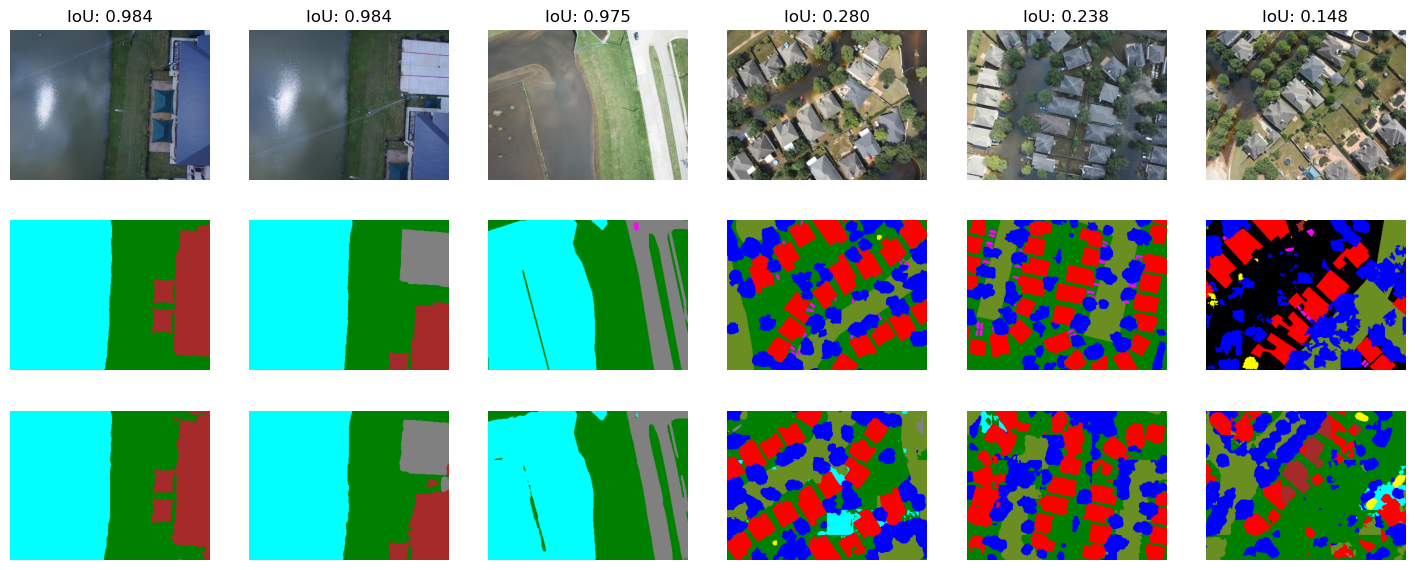

In [35]:
plt.figure(figsize=(18, 7))

for i, (image, true_mask, pred_mask, iou) in enumerate(top_3 + bottom_3):
    plt.subplot(3, 6, i + 1)
    plt.imshow(image)
    plt.title(f'IoU: {iou:.3f}')
    plt.axis('off')

for i, (image, true_mask, pred_mask, iou) in enumerate(top_3 + bottom_3):
    plt.subplot(3, 6, i + 7)
    plt.imshow(true_mask)
    plt.axis('off')

for i, (image, true_mask, pred_mask, iou) in enumerate(top_3 + bottom_3):
    plt.subplot(3, 6, i + 13)
    plt.imshow(pred_mask)
    plt.axis('off')

#plt.subplots_adjust(hspace=0.01)
#plt.tight_layout()
plt.show()
